In [99]:
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from ISLP.svm import plot as plot_svm
import warnings

# Loading Data and Exploration on the Full Dataset

In [ ]:
warnings.filterwarnings('ignore')

Given that the data is provided as a tab separated values, we specify the `sep` argument in the `read_csv` function from pandas to `\t` to make sure that the data is read correctly.

In [42]:
# load data
df = pd.read_csv('data/gene_data.tsv', sep='\t')

Additionally we check whether there are missing data in the dataset and confirm that the dataset is complete with a total of 79 rows and 2002 columns.

In [95]:
print(sum(df.isna().sum(axis=1)))
print(f'shape of the dataset {df.shape}')

0
shape of the dataset (79, 2002)


## Model selection

At this step we preprocess the data to make sure that they can be used to fit a SVM model. We start by specyfing the matrix of predictors and the vector of target labels.

In [102]:
X = df.drop(['y', 'sampleID'], axis=1)
y = df['y']

We also split these into train and test portions for future evaluation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

Then we start fitting different models and comparing them after they have been finetuned through 5-fold CV. Additionally, we scale the data to make sure all features' predictive power is evaluated correctly by the model.

### Linear SVC

In [104]:
svc_model = make_pipeline(StandardScaler(),
              SVC())
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    svc_model,
    {"svc__C": C_values},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [109]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='accuracy')

In [111]:
best_linear_svm = grid.best_estimator_

### Radial Kernel SVM

In [113]:
radial_svm_model = make_pipeline(StandardScaler(),
              SVC())
radial_svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [114]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    radial_svm_model,
    {"svc__C": C_values,
     'svc__gamma': gamma_range},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [115]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [116]:
best_radial_svm_model = grid.best_estimator_

## Model comparison with ROC curves

In [ ]:
roc_curve = RocCurveDisplay.from_estimator 

We first plot the ROC Curve for the linear model and notice how the performance on the test set are not surprisingly good, being only 10% better than random guesses.

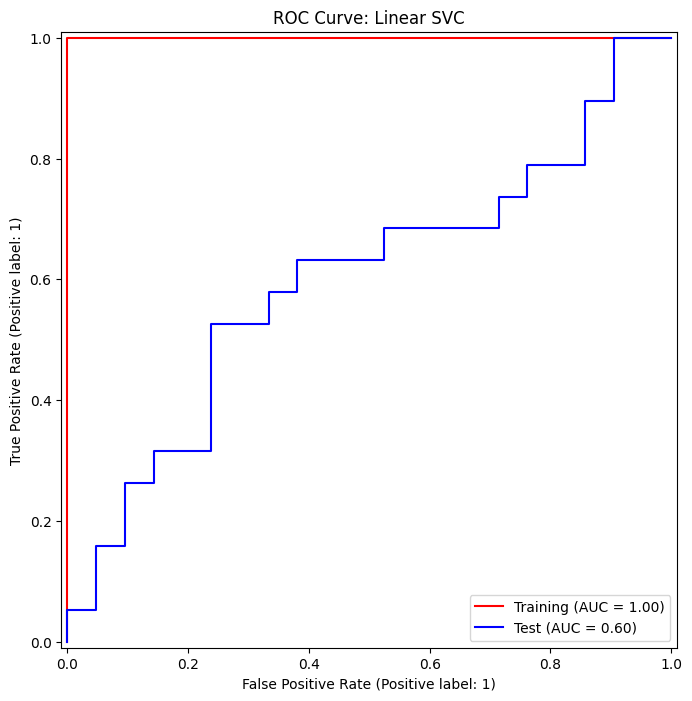

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(best_linear_svm, X_train, y_train, name="Training", color="r", ax=ax)
roc_curve(best_linear_svm, X_test, y_test, name="Test", color="b", ax=ax)
plt.title('ROC Curve: Linear SVC');

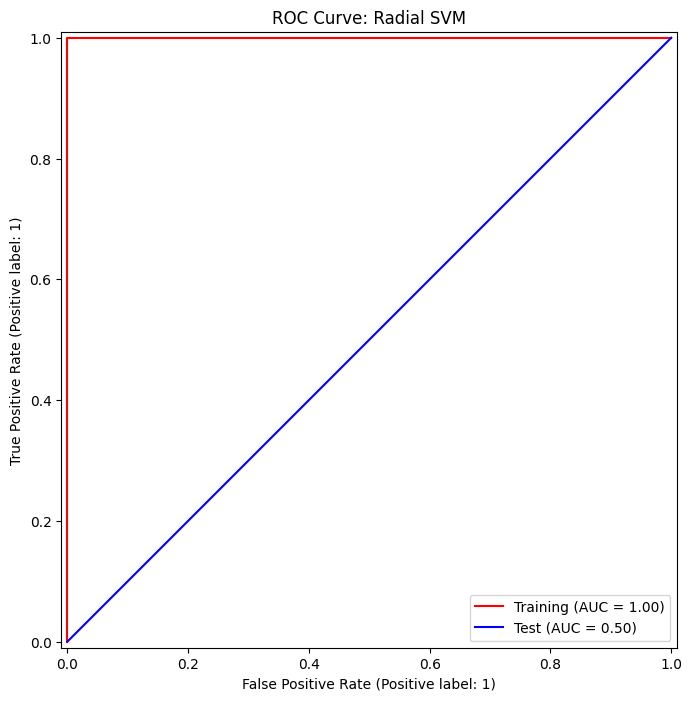

In [124]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(best_radial_svm_model, X_train, y_train, name="Training", color="r", ax=ax)
roc_curve(best_radial_svm_model, X_test, y_test, name="Test", color="b", ax=ax)
plt.title('ROC Curve: Radial SVM');

In [123]:
preds = best_radial_svm_model.predict(X_test)
confusion_matrix(y_true=y_test, y_pred=preds)

array([[21,  0],
       [19,  0]])

For the radial kernel SVM we can easily see how the model is assigning all predictions to the positive class and thus misclassifying all negatively labeled observations.

# Fit on reduced feature set

We now select only the features (genes) that are in the top 5% in terms of variability. 

In [147]:
# Compute standard deviation of each gene (feature)
stds = X.std(axis=0)

# Determine threshold for the top 5% most variable genes
threshold = np.percentile(stds, 95)  # Top 5%

# Select features (genes) with std above the threshold
top_variable_genes = stds[stds > threshold].index

# Filter dataset to include only the selected genes
X_filtered = X[top_variable_genes]
print(f'number of predictors is {X_filtered.shape[1]}')

number of predictors is 100


We can see that now the number of predictors has reduced to 100 thus effectively reducing the noise associated to features that inherently added little to no information to the model. This also helps with reducing the dimensionality of the dataset and might therefore make the fit of SVM models better.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.5, stratify=y,random_state=1)

In [149]:
svc_model = make_pipeline(StandardScaler(),
              SVC())
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [150]:
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    svc_model,
    {"svc__C": C_values},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [151]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='accuracy')

In [152]:
best_linear_svm = grid.best_estimator_

In [153]:
radial_svm_model = make_pipeline(StandardScaler(),
              SVC())
radial_svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [154]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    radial_svm_model,
    {"svc__C": C_values,
     'svc__gamma': gamma_range},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [155]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [156]:
best_radial_svm_model = grid.best_estimator_

## ROC Curves for models fitted on Reduced Dataset

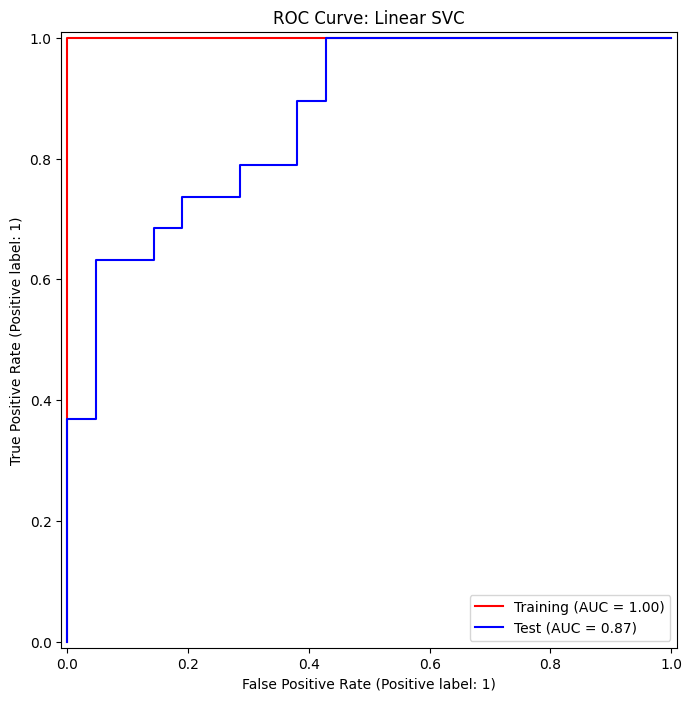

In [157]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(best_linear_svm, X_train, y_train, name="Training", color="r", ax=ax)
roc_curve(best_linear_svm, X_test, y_test, name="Test", color="b", ax=ax)
plt.title('ROC Curve: Linear SVC');

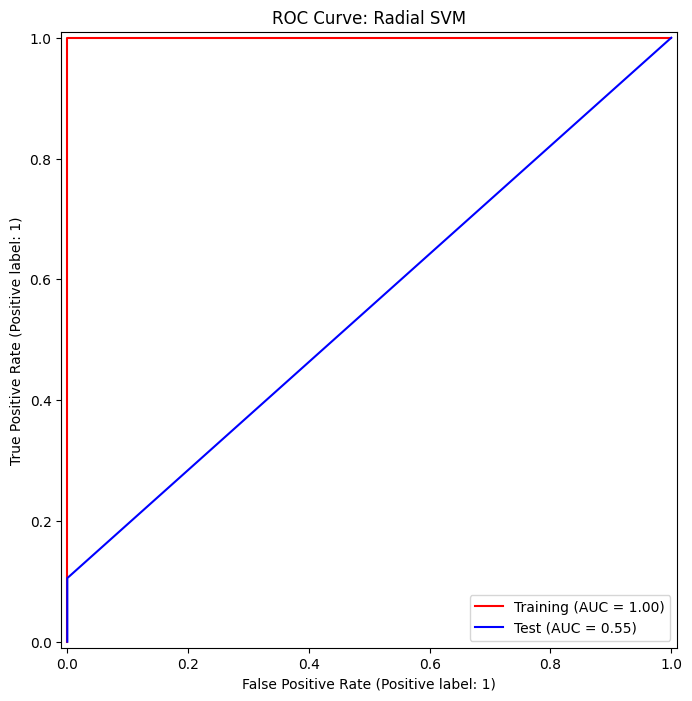

In [158]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_curve(best_radial_svm_model, X_train, y_train, name="Training", color="r", ax=ax)
roc_curve(best_radial_svm_model, X_test, y_test, name="Test", color="b", ax=ax)
plt.title('ROC Curve: Radial SVM');

In [146]:
preds = best_radial_svm_model.predict(X_test)
confusion_matrix(y_true=y_test, y_pred=preds)

array([[21,  0],
       [19,  0]])

# PCA

In [45]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(scaled_X_train)

# plt.figure(figsize=(6, 5))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.6)
# plt.title("PCA Projection of the Dataset")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.show()


# t-SNE


In [46]:
# from sklearn.manifold import TSNE

# X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(scaled_X_train)
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='coolwarm', alpha=0.6)
# plt.title("t-SNE Projection")
# plt.show()

# Pick model
We have to decide which model to use. We have to have a look at the data to determine whether:
1. The data is linearly separable among classes (however, this is not feasible as we are in more than 3 dimensions)
2. 

## Fit SVC
For the simplest model, we have to tune the C (cost) hyperparameter. To this end we perform a 5-fold CV to find the better parameter among a series of values


In [47]:
X = df.drop(['y', 'sampleID'], axis=1)
y = df['y']

In [96]:
selector = VarianceThreshold(threshold=0.05**2)

selector.fit_transform(X, y)
valid_variables = selector.get_feature_names_out()

In [97]:
X = df[valid_variables]
y = df['y']

In [84]:
y.value_counts()

y
-1    42
 1    37
Name: count, dtype: int64

Split into train test each with size equal to 50% of the dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [51]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [52]:
param_grid = {'kernel': ['linear'],
              'C': list(range(1, 10))}

linear_SVM = SVC(random_state=1)

grid = GridSearchCV(linear_SVM, param_grid=param_grid,cv=5)


In [53]:
grid.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'kernel': ['linear']})

In [54]:
best_linear_SVC = grid.best_estimator_

preds = best_linear_SVC.predict(scaled_X_test)

print(classification_report(y_true=y_test, y_pred=preds))

              precision    recall  f1-score   support

          -1       0.76      0.57      0.65        23
           1       0.57      0.76      0.65        17

    accuracy                           0.65        40
   macro avg       0.66      0.66      0.65        40
weighted avg       0.68      0.65      0.65        40



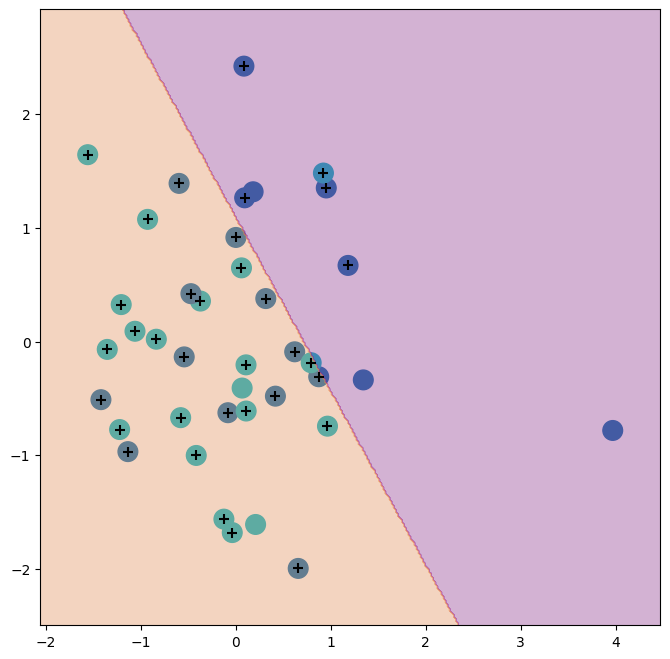

In [55]:
y_train_reset = y_train.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(scaled_X_train, y_train_reset, svm=best_linear_SVC, ax=ax)

In [56]:
confusion_matrix(y_true=y_test, y_pred=preds)

array([[13, 10],
       [ 4, 13]])

In [57]:
(preds == y_test).mean()

np.float64(0.65)

# Support Vector Machine
Now we try to fit an SVM

In [76]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(scaled_X_train, y_train)

SVC(C=1, gamma=1)

In [77]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

params = {"C": C_range, "gamma": gamma_range}

kfold = KFold(5, random_state=0, shuffle=True)

grid = GridSearchCV(svm_rbf, param_grid=params, refit=True, cv=kfold, scoring="accuracy")


In [78]:
grid.fit(scaled_X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=1, gamma=1),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [79]:
grid.best_params_

{'C': 0.1, 'gamma': 0.5}

In [62]:
best_rbf_svm = grid.best_estimator_

In [ ]:
# best_rbf_svm = SVC(kernel='rbf', C=1e5, gamma=1)
# best_rbf_svm.fit(scaled_X_train, y_train)

SVC(C=100000.0, gamma=1)

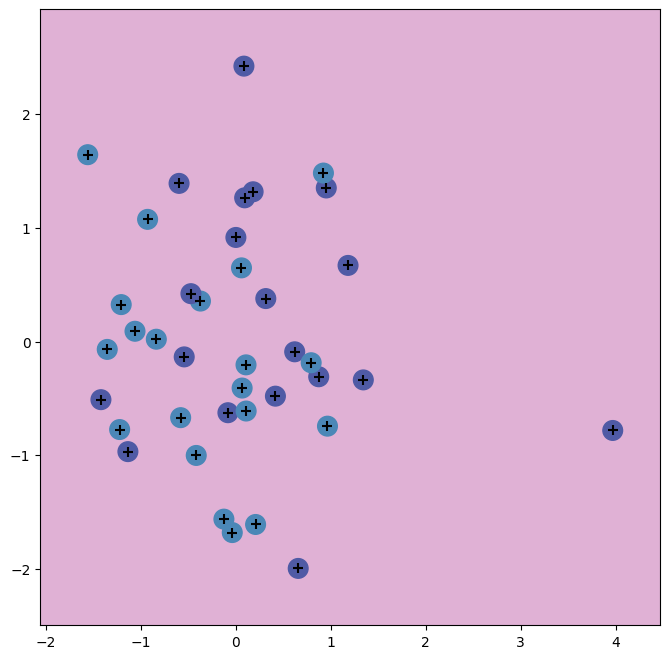

In [89]:
y_train_reset = y_train.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(scaled_X_train, y_train_reset, best_rbf_svm, ax=ax)

In [65]:
preds = best_rbf_svm.predict(scaled_X_test)

print(classification_report(y_true=y_test, y_pred=preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        23
           1       0.42      1.00      0.60        17

    accuracy                           0.42        40
   macro avg       0.21      0.50      0.30        40
weighted avg       0.18      0.42      0.25        40



In [66]:
confusion_matrix(y_true=y_test, y_pred=preds)

array([[ 0, 23],
       [ 0, 17]])

In [67]:
(preds == y_test).mean()

np.float64(0.425)

# Poly SVM

In [68]:
svm_poly = SVC(kernel="poly", gamma=1, C=1)
 #svm_poly.fit(scaled_X_train, y_train)

In [69]:
C_range = [1, 10, 100, 1000]
degree_range = [2, 3, 4, 10]
gamma_range = [0.5, 1, 2, 3, 4]

params = {"C": C_range, "degree": degree_range, "gamma": gamma_range}

kfold = KFold(5, random_state=0, shuffle=True)

grid = GridSearchCV(svm_poly, param_grid=params, refit=True, cv=kfold, scoring="accuracy")

In [70]:
grid.fit(scaled_X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=1, gamma=1, kernel='poly'),
             param_grid={'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 10],
                         'gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [90]:
best_poly_svm = grid.best_estimator_

In [92]:
# best_poly_svm = SVC(kernel='poly', gamma=0.001, degree=8, C=0.1, class_weight='balanced')
# best_poly_svm.fit(scaled_X_train, y_train)

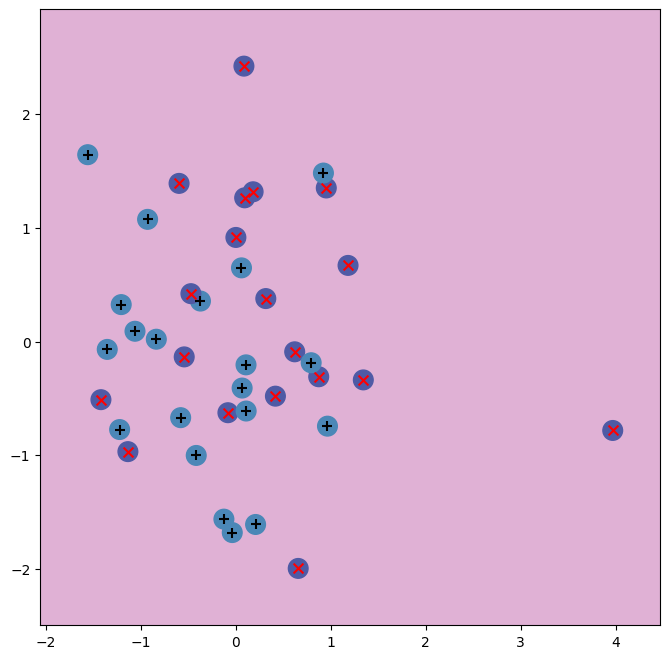

In [93]:
y_train_reset = y_train.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 8))
plot_svm(scaled_X_train, y_train_reset, best_poly_svm, ax=ax)